In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm

from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import pickle, shutil, random
import pandas as pd
import os

In [3]:
#IN_PATH = Path('/project/volume/data/out/KDEF-AKDEF/KDEF_and_AKDEF/KDEF')
LABELS = ['Afraid', 'Angry', 'Disgust', 'Happy', 'Neutral', 'Sad', 'Surprised']

BASE_PATH = Path('/project/volume/data/out/KDEF-AKDEF/')

PROJ_PATH = Path('/project')

JPGS = list(BASE_PATH.rglob('*.JPG'))

print(len(JPGS))


0


In [4]:
def remove_ipynb_checkpoints(path):
    for checkpoint_dir in Path(path).rglob('.ipynb_checkpoints'):
        print("Removing directory:", checkpoint_dir)
        for file in os.listdir(checkpoint_dir):
            file_path = os.path.join(checkpoint_dir, file)
            os.unlink(file_path)
        os.rmdir(checkpoint_dir)

In [6]:
remove_ipynb_checkpoints('/project')

Removing directory: /project/volume/notebooks/.ipynb_checkpoints


Workaround: move files to container, rename, move back :/

In [ ]:
def move_files(file_list, destination):
    for file in tqdm(file_list):
        dest_path = destination / 'KDEF' / file.parent.name
        dest_file = destination / 'KDEF' / file.parent.name / file.name
        dest_path.mkdir(parents=True, exist_ok=True)
        if file.exists() and not dest_file.exists():
            shutil.move(str(file), dest_path)

def rename_jpg_files(file_list):
    for file in tqdm(file_list):
        image_path = Path(file)
        new_path = image_path.with_suffix('.jpg')
        image_path.rename(new_path)

In [ ]:
move_files(JPGS, PROJ_PATH)

proj_jpgs = list((PROJ_PATH / 'KDEF').rglob('*.JPG'))
rename_jpg_files(proj_jpgs)
new_jpgs = list((PROJ_PATH / 'KDEF').rglob('*.jpg'))

move_files(new_jpgs, BASE_PATH)

if Path(PROJ_PATH / 'KDEF').exists():
    shutil.rmtree(str(PROJ_PATH / 'KDEF'))

In [ ]:
IMAGE_PATHS = list(BASE_PATH.rglob('*.jpg'))
IMAGE_PATHS_STR = [str(path) for path in IMAGE_PATHS]

EMOTION_FOLDERS = {
        'AF': 'Afraid',
        'AN': 'Angry',
        'DI': 'Disgusted',
        'HA': 'Happy',
        'NE': 'Neutral',
        'SA': 'Sad',
        'SU': 'Surprised'
        }

print(len(IMAGE_PATHS))

In [ ]:
def create_label_folders():
    for label in tqdm(LABELS):
        dest_path = BASE_PATH / label
        dest_path.mkdir(parents=True, exist_ok=True)

def move_to_folder():
    for file in tqdm(IMAGE_PATHS):
        name = file.stem
        emotion = name[4:6]
        folder_name = EMOTION_FOLDERS.get(emotion)
        if folder_name:
            dest_path = BASE_PATH / folder_name / file.name
            if not dest_path.exists():
                dest_path.parent.mkdir(parents=True, exist_ok=True)
                shutil.move(str(file), str(dest_path))
    if Path(BASE_PATH / 'KDEF').exists():
        shutil.rmtree(str(BASE_PATH / 'KDEF'))

In [ ]:
create_label_folders()
move_to_folder()

In [7]:
IMAGE_PATHS = list(BASE_PATH.rglob('*.jpg'))
IMAGE_PATHS_STR = [str(path) for path in IMAGE_PATHS]

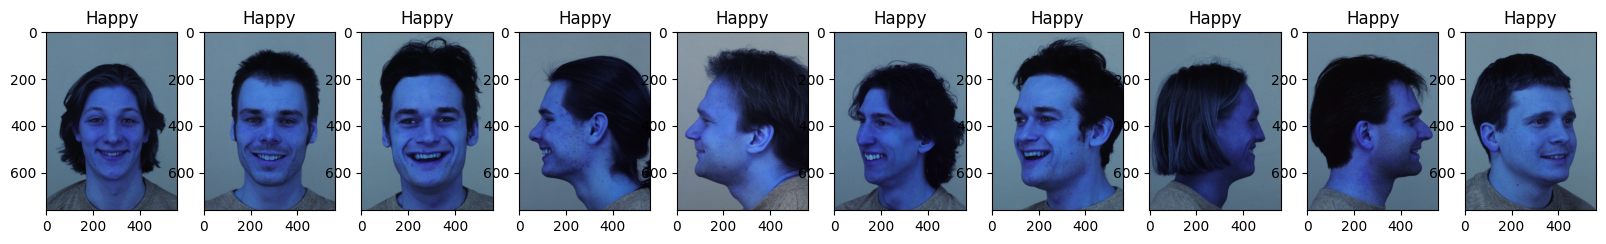

In [8]:
fig = plt.figure(figsize=(20,20))

for i in range(10):

    fig.add_subplot(1, 10, i + 1)
    plt.imshow(np.array(cv2.imread(str(IMAGE_PATHS[i]))), cmap='gray')
    label = Path(IMAGE_PATHS[i]).parent.name
    plt.title(label)

plt.show()

In [9]:
from collections import Counter

{'Happy': 700, 'Sad': 699, 'Neutral': 700, 'Angry': 700, 'Disgusted': 700, 'Surprised': 699, 'Afraid': 700}


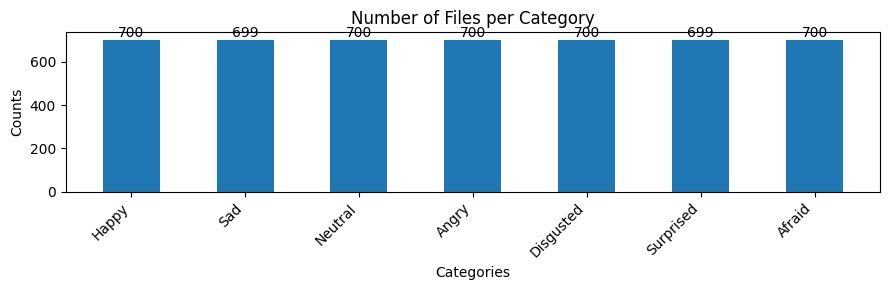

In [10]:
def get_distribution():
    nbr_per_cat = Counter(Path(file).parent.name for file in IMAGE_PATHS)
    print(dict(nbr_per_cat))

    categories = list(nbr_per_cat.keys())
    counts = list(nbr_per_cat.values())

    plt.figure(figsize=(9, 3))
    bars = plt.bar(categories, counts, width=0.5)

    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.title('Number of Files per Category')
    plt.xticks(rotation=45, ha='right')

    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), 
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

get_distribution()

In [ ]:
train_prop = 0.6
test_prop = 0.2
valid_prop = 0.2

number_of_images = len(list(BASE_PATH.rglob('*.jpg')))

n_train = int((number_of_images * train_prop) + 0.5)
n_valid = int((number_of_images * valid_prop) + 0.5)
n_test = number_of_images - n_train - n_valid

print(f"[INFO] Number of images used in training ... {str(n_train)} ({str(train_prop * 100)}%)")
print(f"[INFO] Number of images used in validation ...{str(n_valid)} ({str(valid_prop * 100)}%)")
print(f"[INFO] Number of images used in testing ... {str(n_test)} ({str(test_prop * 100)}%)")

In [ ]:
def split_and_move():
    for label in tqdm(LABELS):
        train_destination = BASE_PATH / "train" / label
        val_destination = BASE_PATH / "val" / label
        test_destination = BASE_PATH / "test" / label

        train_destination.mkdir(parents=True, exist_ok=True)
        val_destination.mkdir(parents=True, exist_ok=True)
        test_destination.mkdir(parents=True, exist_ok=True)

        files = list((BASE_PATH / "train").rglob('*.jpg'))
        random.shuffle(files)

        train_n = (int((len(files) * train_prop) + 0.5))
        val_n = (int((len(files) * valid_prop) + 0.2))
        
        for file_idx, file in enumerate(files):
            if file_idx < train_n:
                shutil.move(str(file), train_destination)
            elif file_idx < train_n + val_n:
                shutil.move(str(file), val_destination)
            else:
                shutil.move(str(file), test_destination)

        if BASE_PATH.exists() and BASE_PATH.is_dir():
            shutil.rmtree(BASE_PATH)

In [ ]:
split_and_move()

## HOG features

In [35]:
def print_score(clf, x_train, y_train, x_test, y_test, train=True):
    if train:
        y_prediction = clf.predict(x_train)
        clf_report = classification_report(y_train, y_prediction)
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, y_prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, y_prediction)}\n")
        
    elif train==False:
        y_prediction = clf.predict(x_test)
        clf_report = classification_report(y_test, y_prediction)
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, y_prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_prediction)}\n")

In [16]:
def to_grayscale(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def resize_image(img, size):
    return cv2.resize(img, (size,size))

In [13]:
def extract_hog_features(image_shape, orientations, pixels_per_cell, cells_per_block):
    compute_hog_feature_size(image_shape, orientations, pixels_per_cell, cells_per_block)
    hog_data = []
    hog_labels = []

    for p in tqdm(IMAGE_PATHS):
        im = to_grayscale(str(p))
        im = resize_image(im, image_shape)
        
        # extract hog feature descriptor
        fd1 = hog(im, orientations=orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                  cells_per_block=(cells_per_block, cells_per_block), 
                  block_norm='L2-Hys',
                  transform_sqrt=False,
                  feature_vector=True)

        label = Path(p).parent.name
        hog_labels.append(label)
        hog_data.append(fd1)

    hog_data = np.array(hog_data)
    hog_labels = np.array(hog_labels)
    print("[INFO] Number of features ...", str(hog_data.shape[1]))
    print("[INFO] Number of labels ...", str(hog_labels.shape[0]))
    return hog_data, hog_labels

def compute_hog_feature_size(image_shape, orientations, pixels_per_cell, cells_per_block):
    height, width = image_shape, image_shape
    num_cells_x = width // pixels_per_cell
    num_cells_y = height // pixels_per_cell
    num_blocks_x = num_cells_x - cells_per_block + 1
    num_blocks_y = num_cells_y - cells_per_block + 1
    features_per_block = cells_per_block * cells_per_block * orientations
    total_features = num_blocks_x * num_blocks_y * features_per_block
    print("[INFO] Size of HOG feature vector ...", total_features)



In [ ]:
hog_data, hog_labels = extract_hog_features(64, 7, 8, 4)

x_train, x_test, y_train, y_test = train_test_split(hog_data, hog_labels, test_size=0.2, shuffle=True, stratify=hog_labels, random_state=42)
print("[INFO] Number of images used in training ...", x_train.shape[0])
print("[INFO] Number of images used in testing ...", x_test.shape[0])

classifier = SVC()
parameters = {'gamma': [0.1], 'C': [1]}

grid_search = GridSearchCV(classifier, parameters, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_estimator_hog = grid_search.best_estimator_
print("[INFO] Best params ...", grid_search.best_params_)

In [ ]:
model_path = Path('/project/volume/models/kdef/hog_model.p')
model_path.parent.mkdir(parents=True, exist_ok=True)

pickle.dump(best_estimator_hog, open(model_path, 'wb'))

print_score(best_estimator_hog, x_train, y_train, x_test, y_test, train=True)
print_score(best_estimator_hog, x_train, y_train, x_test, y_test, train=False)

## Landmarks

In [18]:
from mediapipe import Image
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

import mediapipe as mp

In [19]:
model_path_mesh = '/project/volume/models/face_landmarker.task'

base_options_mesh = python.BaseOptions(model_asset_path=model_path_mesh)
options_mesh = vision.FaceLandmarkerOptions(base_options=base_options_mesh,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector_mesh = vision.FaceLandmarker.create_from_options(options_mesh)

W0000 00:00:1717760003.407381      12 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [ ]:
def read_mp_cv2_image(image_path):
    return Image.create_from_file(str(image_path)), cv2.imread(str(image_path))

def colortogray(img):
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return imgray

def resizeImage(image, size):
    return cv2.resize(image, (size,size))

In [ ]:
def extract_landmarks():
    lm_labels = []
    lm_data = []

    for file in tqdm(IMAGE_PATHS):
        img_cv2 = to_grayscale(str(file))
        img_cv2 = resize_image(img_cv2, 128)
        rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
        detection_result = detector_mesh.detect(rgb_frame)

        if detection_result.face_landmarks:
            lm_array = np.array([[lm.x, lm.y, lm.z] for lm in detection_result.face_landmarks[0]]).flatten()
            lm_labels.append(file.parent.name)
            lm_data.append(lm_array)

    lm_labels = np.array(lm_labels)
    lm_data = np.array(lm_data)

    return lm_data, lm_labels

In [ ]:
lm_data, lm_labels = extract_landmarks()

x_train, x_test, y_train, y_test = train_test_split(lm_data, lm_labels, test_size=0.2, shuffle=True, stratify=hog_labels, random_state=42)
print("[INFO] Number of images used in training ...", x_train.shape[0])
print("[INFO] Number of images used in testing ...", x_test.shape[0])

classifier = SVC()
parameters = {'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100, 1000]}

grid_search = GridSearchCV(classifier, parameters, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_estimator_landmark = grid_search.best_estimator_
print("[INFO] Best params ...", grid_search.best_params_)
pickle.dump(best_estimator_landmark, open('/project/volume/models/lm_model.p', 'wb'))

print_score(best_estimator_landmark, x_train, y_train, x_test, y_test, train=True)
print_score(best_estimator_landmark, x_train, y_train, x_test, y_test, train=False)

In [ ]:
def pure_pixels():
    pixel_labels = []
    pixel_data = []

    for file in tqdm(IMAGE_PATHS):     
        img_cv2 = to_grayscale(str(file))
        img_cv2 = resize_image(img_cv2, 128)
        
        pixel_labels.append(file.parent.name)
        pixel_data.append(np.array(img_cv2).flatten())

    pixel_labels = np.array(pixel_labels)
    pixel_data = np.array(pixel_data)

    return pixel_data, pixel_labels

In [ ]:
pixel_data, pixel_labels = pure_pixels()

x_train, x_test, y_train, y_test = train_test_split(pixel_data, pixel_labels, test_size=0.2, shuffle=True, stratify=hog_labels, random_state=42)
print("[INFO] Number of images used in training ...", x_train.shape[0])
print("[INFO] Number of images used in testing ...", x_test.shape[0])

classifier = SVC()
parameters = {'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100, 1000]}

grid_search = GridSearchCV(classifier, parameters, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_estimator_pixel = grid_search.best_estimator_
print("[INFO] Best params ...", grid_search.best_params_)
pickle.dump(best_estimator_pixel, open('/project/volume/models/pixel_model.p', 'wb'))

print_score(best_estimator_pixel, x_train, y_train, x_test, y_test, train=True)
print_score(best_estimator_pixel, x_train, y_train, x_test, y_test, train=False)

## Blendshapes

In [142]:
def extract_blendshapes():
    bs_labels = []
    bs_data = []

    for file in tqdm(IMAGE_PATHS):
        img_cv2 = to_grayscale(str(file))
        img_cv2 = resize_image(img_cv2, 64)
        
        rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
        detection_result = detector_mesh.detect(rgb_frame)

        if detection_result.face_blendshapes:
            bs_array = np.array([[bs.index, bs.score] for bs in detection_result.face_blendshapes[0]]).flatten()
            bs_labels.append(file.parent.name)
            bs_data.append(bs_array)

    bs_labels = np.array(bs_labels)
    bs_data = np.array(bs_data)

    return bs_data, bs_labels

In [143]:
bs_data, bs_labels = extract_blendshapes()

print(bs_data.shape)
print(bs_labels.shape)    

x_train, x_test, y_train, y_test = train_test_split(bs_data, bs_labels, test_size=0.2, shuffle=True, stratify=bs_labels, random_state=42)
print("[INFO] Number of images used in training ...", x_train.shape[0])
print("[INFO] Number of images used in testing ...", x_test.shape[0])

  0%|                                             | 0/4898 [00:00<?, ?it/s]

(104,)
(0,)
(0,)


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
classifier = SVC()
parameters = {'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100, 1000]}

grid_search = GridSearchCV(classifier, parameters, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_estimator_blendshapes = grid_search.best_estimator_
print("[INFO] Best params ...", grid_search.best_params_)
pickle.dump(best_estimator_blendshapes, open('/project/volume/models/blenshape_model.p', 'wb'))


In [ ]:
print_score(best_estimator_pixel, x_train, y_train, x_test, y_test, train=True)
print_score(best_estimator_pixel, x_train, y_train, x_test, y_test, train=False)

## K-fold Cross_validation

In [ ]:
n_splits_values = [3, 5, 10]

In [ ]:
classifier = SVC()
parameters = {'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100, 1000]}
"""
modes = {'hog': best_estimator_hog, 
         'pixel': best_estimator_pixel,
         'landmark': best_estimator_landmark, 
         'blendshapes': best_estimator_blendshapes
         }
"""
modes = {
         'blendshapes': best_estimator_blendshapes
         }


In [ ]:
for mode, model in modes.items():
    print(mode)
    for n_splits in n_splits_values:
        cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
        scores = cross_val_score(model, bs_data, bs_labels, scoring='accuracy', cv=cv, n_jobs=-1)
        print(f"{n_splits}-Fold CV: {scores.mean():.2f} accuracy with a standard deviation of {scores.std():.2f}")

## HOG + Landmarks

In [28]:
def hog_landmarks(image_shape, orientations, pixels_per_cell, cells_per_block):

    compute_hog_feature_size(image_shape, orientations, pixels_per_cell, cells_per_block)

    data = []
    labels = []

    for file in tqdm(IMAGE_PATHS):
        img_cv2 = to_grayscale(str(file))
        img_cv2 = resize_image(img_cv2, image_shape)
        rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
        
        # extract hog feature descriptor
        fd1 = hog(img_cv2, orientations=orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                  cells_per_block=(cells_per_block, cells_per_block), 
                  block_norm='L2-Hys',
                  transform_sqrt=False,
                  feature_vector=True)
        
        # extract landmarks
        detection_result = detector_mesh.detect(rgb_frame)
        if detection_result.face_landmarks:
            landmarks = np.array([[lm.x, lm.y, lm.z] for lm in detection_result.face_landmarks[0]]).flatten()
        
        features = np.concatenate((fd1, landmarks)).flatten() 
        labels.append(file.parent.name)
        data.append(features)

    data = np.array(data)
    labels = np.array(labels)
        
    print("[INFO] Number of features ...", str(data.shape[1]))
    print("[INFO] Number of labels ...", str(labels.shape[0]))
        
    return data, labels
        

    

In [29]:
data, labels = hog_landmarks(64, 7, 8, 4)

[INFO] Size of HOG feature vector ... 2800


  0%|                                                                        | 0/4898 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████| 4898/4898 [01:33<00:00, 52.45it/s]


[INFO] Number of features ... 4234
[INFO] Number of labels ... 4898


In [30]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42)
print("[INFO] Number of images used in training ...", x_train.shape[0])
print("[INFO] Number of images used in testing ...", x_test.shape[0])

[INFO] Number of images used in training ... 3918
[INFO] Number of images used in testing ... 980


In [32]:
classifier = SVC()
parameters = {'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100, 1000]}

grid_search = GridSearchCV(classifier, parameters, n_jobs=-1)
grid_search.fit(x_train, y_train)


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001]})

In [38]:

best_estimator_combined = grid_search.best_estimator_
print("[INFO] Best params ...", grid_search.best_params_)
pickle.dump(best_estimator_combined, open('/project/volume/models/combined_model.p', 'wb'))


[INFO] Best params ... {'C': 100, 'gamma': 0.01}


In [39]:
print_score(best_estimator_combined, x_train, y_train, x_test, y_test, train=True)
print_score(best_estimator_combined, x_train, y_train, x_test, y_test, train=False)

Train Result:
Accuracy Score: 99.80%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Afraid       1.00      1.00      1.00       560
       Angry       1.00      1.00      1.00       560
   Disgusted       1.00      1.00      1.00       560
       Happy       1.00      1.00      1.00       560
     Neutral       1.00      1.00      1.00       560
         Sad       1.00      1.00      1.00       559
   Surprised       1.00      1.00      1.00       559

    accuracy                           1.00      3918
   macro avg       1.00      1.00      1.00      3918
weighted avg       1.00      1.00      1.00      3918

_______________________________________________
Confusion Matrix: 
 [[558   0   1   0   0   0   1]
 [  0 559   0   0   0   1   0]
 [  0   1 559   0   0   0   0]
 [  0   0   0 560   0   0   0]
 [  0   0   1   0 559   0   0]
 [  1   0   0   0   1 557   0]
 [  1   0   0   0   0   0 558]]

Test Res

In [40]:
n_splits_values = [3, 5, 10]

In [42]:
classifier = SVC()
parameters = {'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100, 1000]}

modes = { 'combined' : best_estimator_combined }

for mode, model in modes.items():
    print(mode)
    for n_splits in n_splits_values:
        cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
        scores = cross_val_score(model, data, labels, scoring='accuracy', cv=cv, n_jobs=-1)
        print(f"{n_splits}-Fold CV: {scores.mean():.2f} accuracy with a standard deviation of {scores.std():.2f}")

combined
3-Fold CV: 0.45 accuracy with a standard deviation of 0.02
5-Fold CV: 0.46 accuracy with a standard deviation of 0.01
10-Fold CV: 0.48 accuracy with a standard deviation of 0.02
